In [11]:
import leafmap
import geopandas as gpd
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import json
from shapely import wkt
import torch
from samgeo import SamGeo, SamGeo2, raster_to_vector, overlay_images

In [12]:
fire_name = "santa-rosa"
pic_number = "0014"
pre_image_f = f"../fires/{fire_name}/images/{fire_name}-wildfire_0000{pic_number}_pre_disaster.tif"
post_image_f = f"../fires/{fire_name}/images/{fire_name}-wildfire_0000{pic_number}_post_disaster.tif"
pre_label_f = f"../fires/{fire_name}/labels/{fire_name}-wildfire_0000{pic_number}_pre_disaster.json"
post_label_f = f"../fires/{fire_name}/labels/{fire_name}-wildfire_0000{pic_number}_post_disaster.json"

pre_image = rasterio.open(pre_image_f)
post_image = rasterio.open(post_image_f)

pre_image_data = pre_image.read([1,2,3])
pre_image_data = pre_image_data.transpose(1,2,0)
post_image_data = post_image.read([1,2,3])
post_image_data = post_image_data.transpose(1,2,0)

with open(pre_label_f, 'r') as f:
    pre_label_data = json.load(f)

with open(post_label_f, 'r') as f:
    post_label_data = json.load(f)

In [4]:
def inspect_tif(path):
    with rasterio.open(path) as src:
        print(f"\n📂 Inspecting: {path}")
        print("Shape (height, width):", (src.height, src.width))
        print("Number of bands:", src.count)
        res_x, res_y = src.res
        print("Pixel size (X):", res_x)
        print("Pixel size (Y):", res_y)
        print("CRS:", src.crs)
        print("Affine Transform:", src.transform)
        print("Band order and descriptions:")

        for i in range(1, src.count + 1):
            desc = src.descriptions[i-1] or f"Band {i}"
            dtype = src.dtypes[i-1]
            stats = src.read(i).min(), src.read(i).max()
            shape = src.read(i).shape
            print(f"  - Band {i}: {desc}, dtype: {dtype}, min-max: {stats}, shape: {shape}")

In [5]:
inspect_tif(pre_image_f)


📂 Inspecting: ../fires/santa-rosa/images/santa-rosa-wildfire_00000014_pre_disaster.tif
Shape (height, width): (1024, 1024)
Number of bands: 3
Pixel size (X): 4.6166550511485966e-06
Pixel size (Y): 4.6166550511485966e-06
CRS: EPSG:4326
Affine Transform: | 0.00, 0.00,-122.74|
| 0.00,-0.00, 38.50|
| 0.00, 0.00, 1.00|
Band order and descriptions:
  - Band 1: Band 1, dtype: int16, min-max: (np.int16(0), np.int16(255)), shape: (1024, 1024)
  - Band 2: Band 2, dtype: int16, min-max: (np.int16(0), np.int16(255)), shape: (1024, 1024)
  - Band 3: Band 3, dtype: int16, min-max: (np.int16(0), np.int16(255)), shape: (1024, 1024)


In [13]:
import rasterio
import numpy as np

def normalize_to_uint8_per_band(image_path, export=False, export_path="norm_img.tif"):
    """
    Normalizes a multi-band image to 0–255 per band and converts to uint8.
    Expects a path to a .tif file.
    If export=True, saves normalized image to a GeoTIFF at `export_path`.
    Returns: normalized image (H, W, C) as uint8
    """

    with rasterio.open(image_path) as src:
        image = src.read([1, 2, 3])  # shape: (C, H, W)
        meta = src.meta.copy()

    # Transpose to (H, W, C)
    if image.shape[0] in [1, 2, 3, 4, 5]:  # (C, H, W) → (H, W, C)
        image = np.transpose(image, (1, 2, 0))

    norm_image = np.zeros_like(image, dtype=np.uint8)

    for i in range(image.shape[2]):
        band = image[:, :, i].astype(np.float32)
        band -= band.min()
        if band.max() > 0:
            band /= band.max()
        band *= 255
        norm_image[:, :, i] = band.astype(np.uint8)

    if export:
        # Update metadata after we're sure norm_image is final
        meta.update({
            'count': norm_image.shape[2],
            'dtype': 'uint8'
        })

        meta.update({'nodata': 0})

        # Transpose back to (C, H, W) for writing
        norm_image_raster = norm_image.transpose(2, 0, 1)

        with rasterio.open(export_path, 'w', **meta) as dst:
            dst.write(norm_image_raster)

    return norm_image


In [17]:
import json
import geopandas as gpd
from shapely import wkt

def export_xbd_json_to_shapefile(json_path, output_path):
    # Load the JSON
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Extract features from 'xy' block (pixel-based)
    # features = data['features']['xy']
    features  = data['features']['lng_lat']  # If you want to use 'lng_lat' instead

    geometries = []
    attributes = []

    for feature in features:
        # Parse WKT geometry
        geom = wkt.loads(feature['wkt'])
        geometries.append(geom)

        # Get properties (like damage subtype and uid)
        props = feature.get('properties', {})
        attributes.append(props)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(attributes, geometry=geometries)

    # Set CRS — if you're in pixel space, leave it undefined (or set it manually if needed)
    # If you switch to 'lng_lat' instead of 'xy', then:
    gdf.set_crs("EPSG:4326", inplace=True)

    # Save to shapefile
    gdf.to_file(output_path, driver='ESRI Shapefile')
    print(f"✅ Saved to {output_path}")


In [ ]:
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

def reproject_raster_to_utm(src_path, dst_path):
    with rasterio.open(src_path) as src:
        # Estimate target CRS (UTM zone based on image center)
        from pyproj import CRS
        utm_crs = CRS.from_user_input(src.crs).get_utm_crs(src.xy(src.height // 2, src.width // 2)[1])

        transform, width, height = calculate_default_transform(
            src.crs, utm_crs, src.width, src.height, *src.bounds
        )

        kwargs = src.meta.copy()
        kwargs.update({
            'crs': utm_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(dst_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=utm_crs,
                    resampling=Resampling.bilinear
                )
    return dst_path, utm_crs


In [18]:
export_xbd_json_to_shapefile(pre_label_f, "b_footprints.shp")

✅ Saved to b_footprints.shp


In [19]:
# Load the lng_lat footprints
gdf = gpd.read_file("b_footprints.shp")

# Reproject to match image's CRS — for example, UTM Zone 10N = EPSG:32610
gdf_utm = gdf.to_crs("EPSG:32610")

# Save to new shapefile
gdf_utm.to_file("footprints_utm.shp")

In [ ]:
import rasterio.plot
import matplotlib.pyplot as plt

with rasterio.open("reprojected_santarosa14.tif") as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    rasterio.plot.show(src, ax=ax)
    gdf_utm = gpd.read_file("footprints_utm.shp")
    gdf_utm.plot(ax=ax, facecolor="none", edgecolor="red", linewidth=1)
    plt.show()

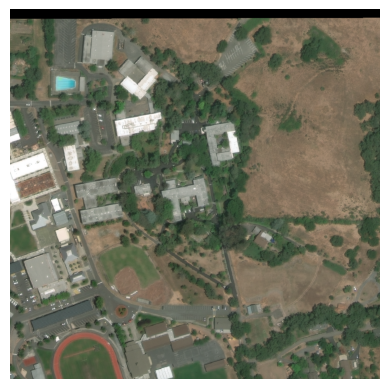

In [14]:
norm_pre = normalize_to_uint8_per_band(pre_image_f, export=True)
plt.imshow(norm_pre)
plt.axis("off")
plt.show()

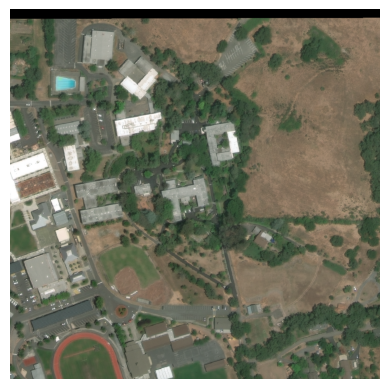

In [15]:
plt.imshow(pre_image_data)
plt.axis("off")
plt.show()

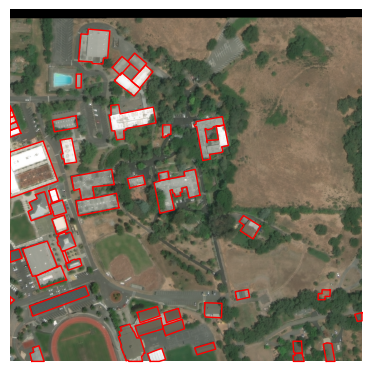

In [9]:
# Example: draw the first structure
poly = wkt.loads(pre_label_data['features']['xy'][0]['wkt'])

# Plot
fig, ax = plt.subplots()
ax.imshow(pre_image_data)  # your loaded and transposed image

for feature in pre_label_data['features']['xy']:
    poly = wkt.loads(feature['wkt'])
    x, y = poly.exterior.xy
    ax.plot(x, y, color='red', linewidth=1)

plt.axis('off')
plt.show()


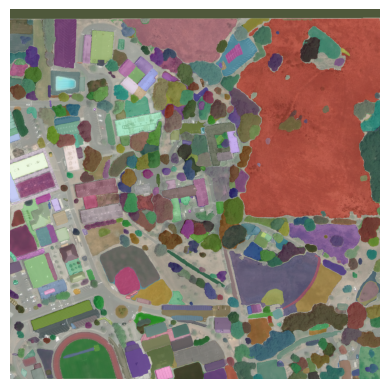

In [10]:
ann_img = rasterio.open("./Images/annotation.tif")
ann_img_data = ann_img.read([1,2,3])
ann_img_data = ann_img_data.transpose(1,2,0)

plt.imshow(ann_img_data)
plt.axis("off")
plt.show()

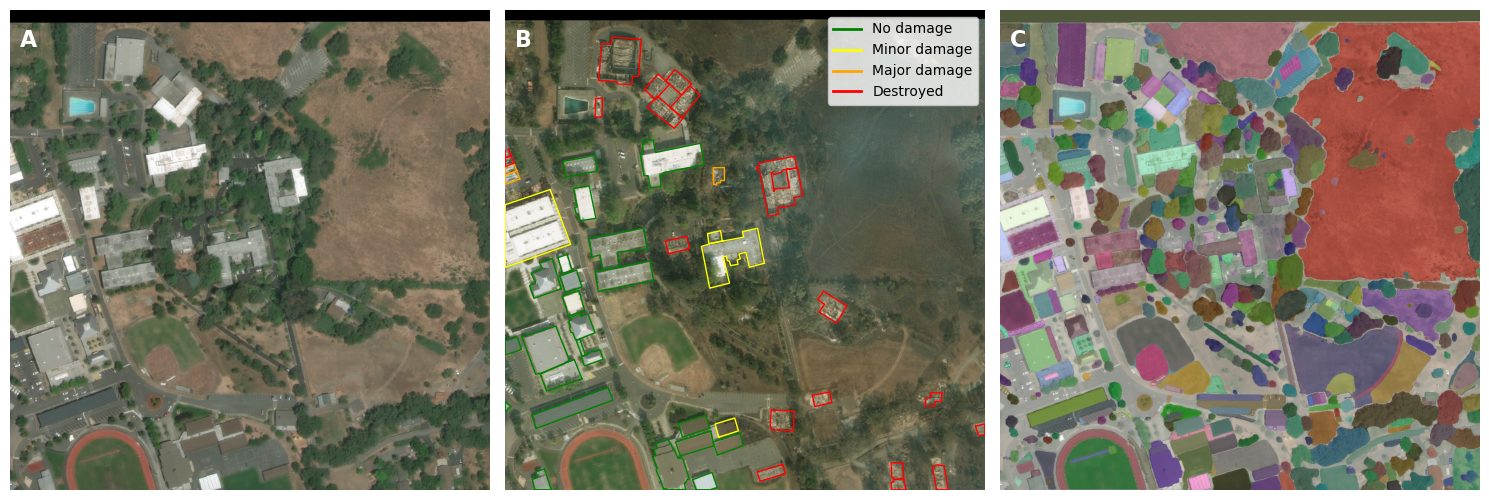

In [ ]:
# Define a color map for damage levels
damage_colors = {
    "no-damage": "green",
    "minor-damage": "yellow",
    "major-damage": "orange",
    "destroyed": "red"
}

fig, axes = plt.subplots(1, 3, figsize=(15, 8))

axes[0].imshow(pre_image_data)
axes[0].axis('off')
axes[0].text(
        0.02, 0.96, "A",                # (x, y) in axes fraction coordinates
        transform=axes[0].transAxes,               # makes coordinates relative to axes (0–1)
        fontsize=16, fontweight='bold',
        va='top', ha='left', color='white'    # align top-left
    )


ax = axes[1]

ax.imshow(post_image_data)

for feature in post_label_data['features']['xy']:
    damage_level = feature['properties'].get('subtype', 'no-damage')
    poly = wkt.loads(feature['wkt'])
    x, y = poly.exterior.xy
    color = damage_colors.get(damage_level, 'gray')  # fallback if unknown
    ax.plot(x, y, color=color, linewidth=1)

# Optional: add legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color=color, lw=2, label=label.replace('-', ' ').capitalize())
    for label, color in damage_colors.items()
]

ax.legend(handles=legend_elements)
ax.axis('off')
ax.text(
        0.02, 0.96, "B",                # (x, y) in axes fraction coordinates
        transform=ax.transAxes,               # makes coordinates relative to axes (0–1)
        fontsize=16, fontweight='bold',
        va='top', ha='left', color='white'    # align top-left
    )

axes[2].imshow(ann_img_data)
axes[2].axis('off')
axes[2].text(
        0.02, 0.96, "C",                # (x, y) in axes fraction coordinates
        transform=axes[2].transAxes,               # makes coordinates relative to axes (0–1)
        fontsize=16, fontweight='bold',
        va='top', ha='left', color='white'    # align top-left
    )

plt.tight_layout()
#plt.savefig("xBD_Analysis.png", dpi=300, bbox_inches="tight")
plt.show()


In [11]:
sam_kwargs = {
    "points_per_side": 32,
    "pred_iou_thresh": 0.86,
    "stability_score_thresh": 0.92,
    "crop_n_layers": 1,
    "crop_n_points_downscale_factor": 2,
    "min_mask_region_area": 80,
}

sam = SamGeo(
    model_type="vit_h",
    sam_kwargs=sam_kwargs,
)

Model checkpoint for vit_h not found.


Downloading...
From: https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
To: /users/k24109631/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.56G/2.56G [00:08<00:00, 293MB/s]


In [16]:
sam.generate("norm_img.tif", output="mask.tif", foreground=False)
raster_to_vector("mask.tif", output="mask.shp")
sam.show_masks(cmap="binary_r")
sam.show_anns(axis="off", opacity=1, output="annotation.tif")

NameError: name 'sam' is not defined

In [4]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    device="cuda",
    apply_postprocessing=False,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=4,
    crop_nms_thresh=0.8,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.9,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0.1,
    use_m2m=True,
)

In [4]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    apply_postprocessing=False,
    points_per_side=32,
    points_per_batch=64,
    pred_iou_thresh=0.8,
    stability_score_thresh=0.92,
    stability_score_offset=0.7,
    crop_n_layers=2,
    crop_nms_thresh=0.8,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.9,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=0.1,
    use_m2m=True,
)

In [17]:
sam2 = SamGeo2(
    model_id="sam2-hiera-large",
    apply_postprocessing=False,
    points_per_side=128,
    points_per_batch=64,
    pred_iou_thresh=0.85,
    stability_score_thresh=0.9,
    stability_score_offset=0.7,
    crop_n_layers=1,
    crop_nms_thresh=0.5,
    crop_overlap_ratio=0.1,
    box_nms_thresh=0.5,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=5,
    use_m2m=True,
)

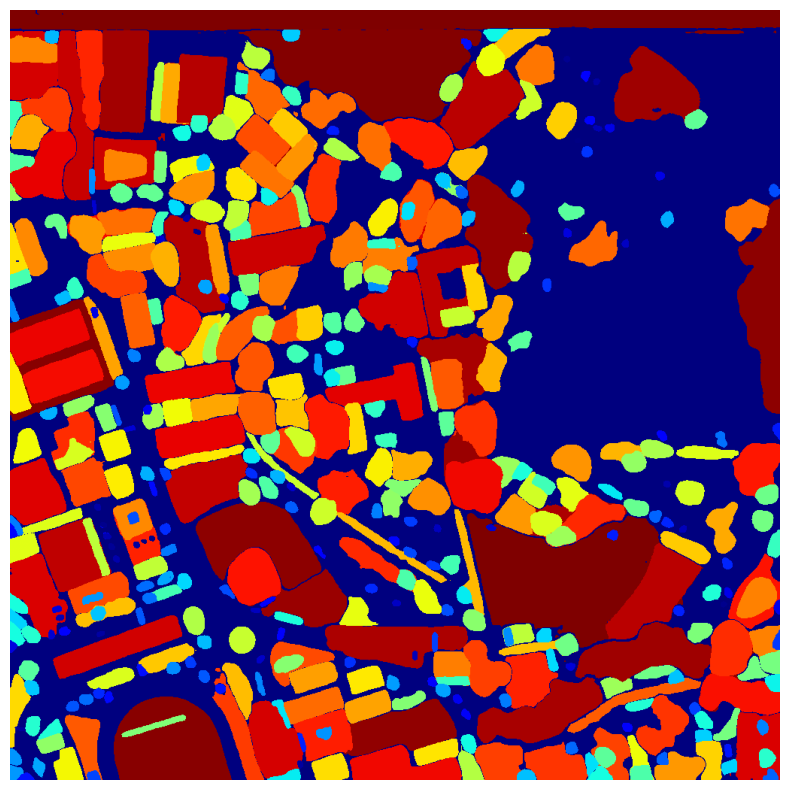

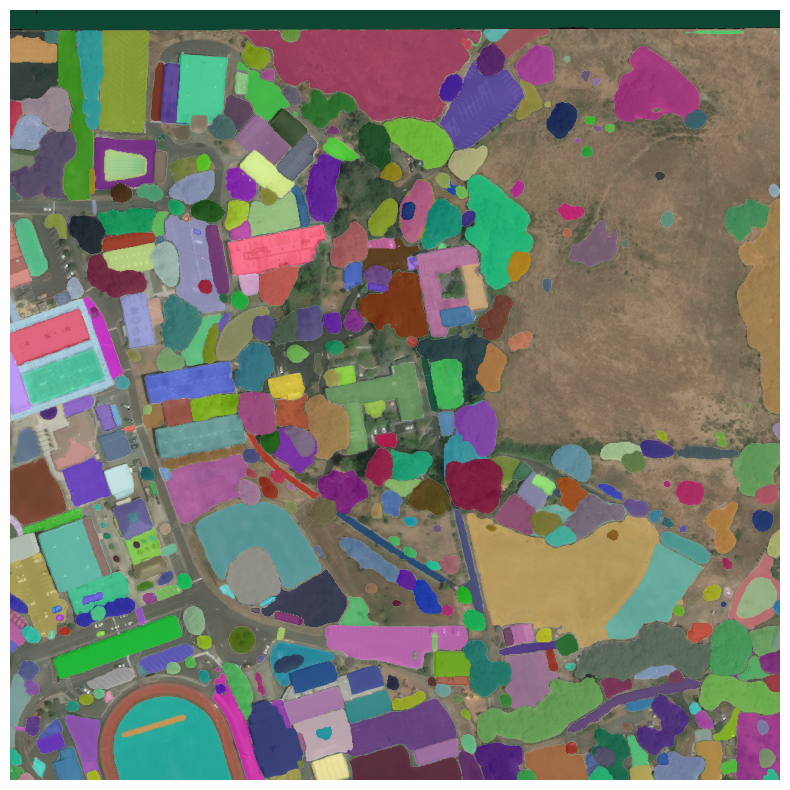

In [18]:
sam2.generate("norm_img.tif", output="masks2.tif")
sam2.show_masks(cmap="jet")
sam2.show_anns(axis="off", alpha=0.6, output="annotations2.tif")